In [1]:

from astropy.table import Table, join
from astropy.cosmology import Planck18 as cosmo
from matplotlib import pyplot as plt
from tqdm import tqdm
from copy import deepcopy
from scipy.optimize import minimize
from scipy.special import erfc


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
from sklearn.metrics import roc_curve, auc
import warnings

import sncosmo
import lcdata

import parsnip

import warnings
warnings.filterwarnings('ignore')



In [2]:
model = parsnip.load_model('../parsnip-mod/models/model_roman_full.pt')
roman_classifier = parsnip.Classifier()
roman_train = lcdata.read_hdf5('roman_train.h5')
pred_train = model.predict_dataset(roman_train)
dataset = lcdata.read_hdf5('roman_test.h5')
pred_test = model.predict_dataset(dataset, augment=True)
pred_test['original_object_id'] = pred_test['object_id']


Preprocessing dataset: 100%|██████████| 5985/5985 [00:04<00:00, 1459.22it/s]


In [4]:
roman_classifier = parsnip.Classifier()
pred_train['original_object_id'] = pred_train['object_id']
classifications_train = roman_classifier.train(pred_train, num_folds=10)
classifications = roman_classifier.classify(pred_test)


Training classifier with keys:
    color
    color_error
    s1
    s1_error
    s2
    s2_error
    s3
    s3_error
    luminosity
    luminosity_error
    reference_time_error
Label distribution before folding: (array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 1100, 42195,    32,     9,    65, 15731,   832,    36]))
[100]	valid_0's multi_logloss: 0.601232
[100]	valid_0's multi_logloss: 0.651576
[100]	valid_0's multi_logloss: 0.534159
[100]	valid_0's multi_logloss: 0.803482
[100]	valid_0's multi_logloss: 0.629607
[100]	valid_0's multi_logloss: 0.80064
[100]	valid_0's multi_logloss: 1.06359
[100]	valid_0's multi_logloss: 1.07814
[100]	valid_0's multi_logloss: 0.557861
[100]	valid_0's multi_logloss: 0.569897


In [54]:
df_test = pred_test.to_pandas()
df_train = pred_train.to_pandas()

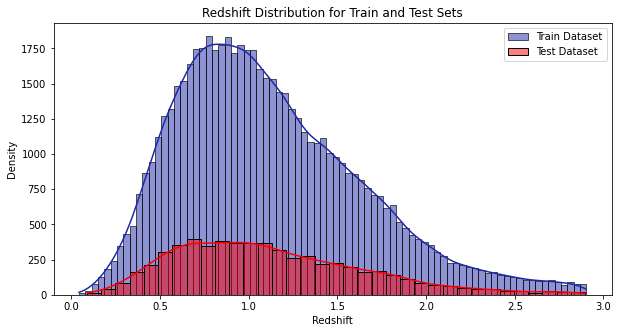

In [62]:

# Plotting KDE plots
plt.figure(figsize=(10, 5))
sns.histplot(df_train['redshift'],color='#1F28AB', label='Train Dataset',kde=True)
sns.histplot(df_test['redshift'],color='#FB0006', label='Test Dataset',kde=True)


# Calculate statistics for train data
train_mean = df_train['redshift'].mean()
train_quartiles = np.percentile(df_train['redshift'], [25, 50, 75])

# Calculate statistics for test data
test_mean = df_test['redshift'].mean()
test_quartiles = np.percentile(df_test['redshift'], [25, 50, 75])

# Adding labels and title
plt.xlabel('Redshift')
plt.ylabel('Density')
plt.title('Redshift Distribution for Train and Test Sets')
plt.savefig('./figures/redshift_histogram_kde.pdf')
plt.legend(loc='upper right')

# Showing the plot
plt.show()


Training classifier with keys:
    color
    color_error
    s1
    s1_error
    s2
    s2_error
    s3
    s3_error
    luminosity
    luminosity_error
    reference_time_error
Label distribution before folding: (array([0, 1]), array([15731, 44269]))
[100]	valid_0's binary_logloss: 0.174047
[100]	valid_0's binary_logloss: 0.177017
[100]	valid_0's binary_logloss: 0.192754
[100]	valid_0's binary_logloss: 0.182074
[100]	valid_0's binary_logloss: 0.178887
[100]	valid_0's binary_logloss: 0.182398
[100]	valid_0's binary_logloss: 0.178061
[100]	valid_0's binary_logloss: 0.192993
[100]	valid_0's binary_logloss: 0.182371
[100]	valid_0's binary_logloss: 0.170808
Training classifier with keys:
    color
    color_error
    s1
    s1_error
    s2
    s2_error
    s3
    s3_error
    luminosity
    luminosity_error
    reference_time_error
Label distribution before folding: (array([0, 1]), array([  832, 59168]))
[100]	valid_0's binary_logloss: 0.263338
[100]	valid_0's binary_logloss: 0.283922
[100

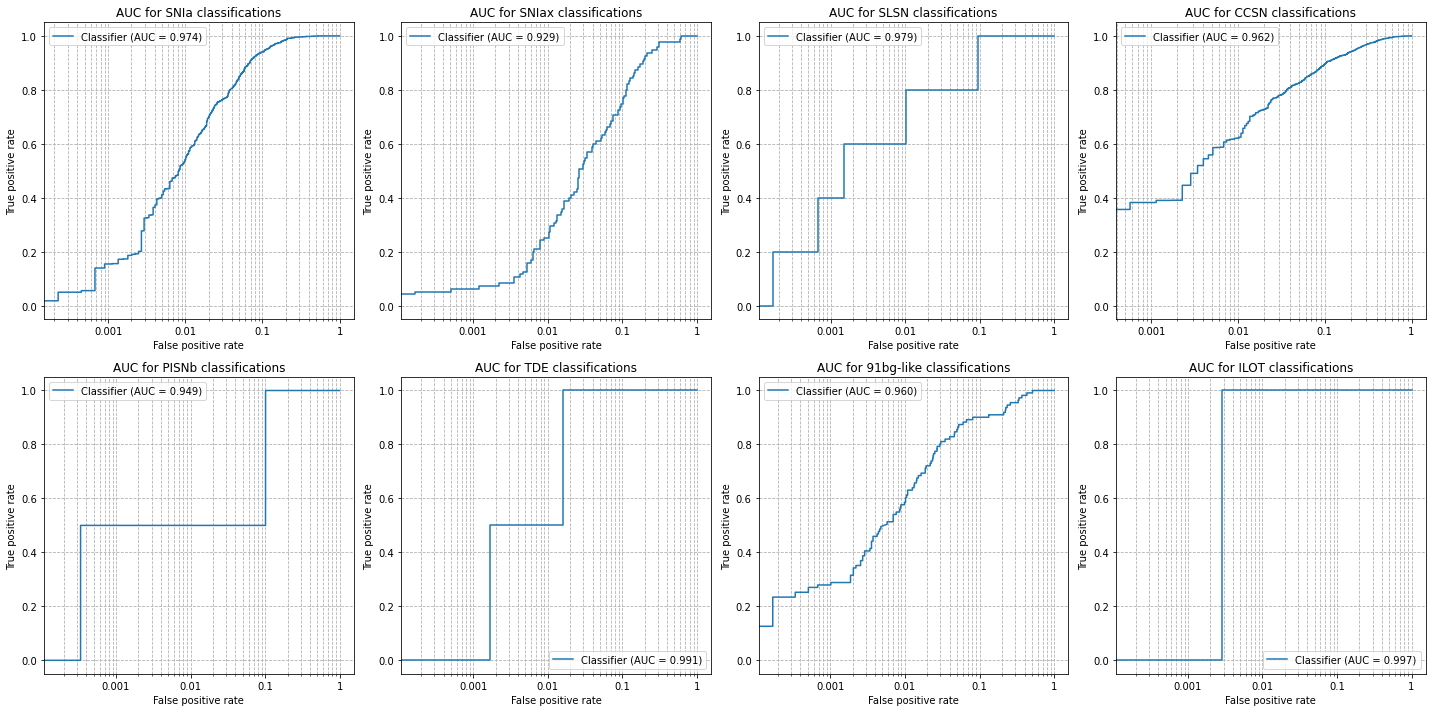

In [13]:

def plot_roc_curve(ax, pred_train, pred_test, target, classifier):
    """
    Plots the ROC curve for a given target classification on a given axis.

    Parameters:
    ax (matplotlib.axes.Axes): The axis to plot the ROC curve on
    pred_train (DataFrame): Training data with features and labels
    pred_test (DataFrame): Test data with features
    target (str): The target label for classification
    classifier (Classifier): The classifier object with train and classify methods
    """
    pred_train['original_object_id'] = pred_train['object_id']
    classifications_train = classifier.train(pred_train, num_folds=10, target_label=target)
    preds_copy = pred_test.copy()
    classifications = classifier.classify(preds_copy)
    
    fpr, tpr, thresholds = roc_curve(pred_test['type'] == target, classifications[target])
    ax.plot(fpr, tpr, label=f'{classifier.__class__.__name__} (AUC = {auc(fpr, tpr):.3f})')
    
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_xscale('log')
    ax.set_title(f'AUC for {target} classifications')
    ax.legend()
    ax.grid(True, which="both", ls="--")
    ax.set_xticks([0.001, 0.01, 0.1, 1])
    ax.set_xticklabels(['0.001', '0.01', '0.1', '1'])


fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, sn_type in enumerate(sn_types):
    ax = axes[i // 4, i % 4]
    plot_roc_curve(ax, pred_train, pred_test, sn_type, roman_classifier)

plt.tight_layout()
plt.savefig('./figures/roc_curve_log_combined.pdf')
plt.show()


In [27]:

# Ignore all warnings
warnings.filterwarnings("ignore")

def plot_auc(target, pred, key, label, ax, num_bins=100, binrange=None):
    val = pred_test[key]

    xvals = []
    aucs = []

    if binrange is None:
        bins = np.linspace(0, 100, num_bins+1)
    else:
        bins = np.linspace(binrange[0], binrange[1], num_bins+1)
        
    for bin_idx in range(num_bins):
        if binrange is None:
            cut = (val >= np.percentile(val, bins[bin_idx])) & (val < np.percentile(val, bins[bin_idx + 1]))
        else:
            cut = (val > bins[bin_idx]) & (val < bins[bin_idx + 1])
        
        if np.sum(cut) == 0:
            continue
        
        fpr, tpr, thresholds = roc_curve(target[cut], pred[cut], pos_label=1)
        aucs.append(auc(fpr, tpr))

        xvals.append(np.mean(val[cut]))

    ax.plot(xvals, aucs, label=label)
    ax.set_xlabel(key)
    ax.set_ylabel('AUC')
    ax.legend()

def plot_selected_sn_types(pred_train, pred_test, sn_types, classifier, save_path='./figures/'):
    pred_train['original_object_id'] = pred_train['object_id']
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)
    axes = axes.flatten()
    
    key = 'redshift'
    
    for i, sn_type in enumerate(sn_types):
        # Define target as boolean array
        target = (pred_test['type'] == sn_type).astype(int)

        # Train the classifier
        classifications_train = classifier.train(pred_train, num_folds=10, target_label=sn_type)
        preds_copy = pred_test.copy()
        classifications = classifier.classify(preds_copy)
        
        # Print the keys of the classifications dictionary for debugging
        print(f"Classifications keys: {list(classifications.keys())}")

        # Ensure the key exists in the classifications DataFrame
        if sn_type not in classifications.columns:
            print(f"Warning: {sn_type} not found in classifications")
            continue

        plot_auc(target, classifications[sn_type], key, sn_type, axes[i], binrange=(0, 1.5))
    
    fig.suptitle('AUC vs. Redshift for SNIa and CCSN')
    save_file = f'{save_path}auc_redshift_selected_types.pdf'
    plt.savefig(save_file)
    plt.close()
    print(f'ROC curve saved to {save_file}')

# Example usage:
sn_types = ['SNIa', 'CCSN']
plot_selected_sn_types(pred_train, pred_test, sn_types, roman_classifier)


Training classifier with keys:
    color
    color_error
    s1
    s1_error
    s2
    s2_error
    s3
    s3_error
    luminosity
    luminosity_error
    reference_time_error
Label distribution before folding: (array([0, 1]), array([15731, 44269]))
[100]	valid_0's binary_logloss: 0.174047
[100]	valid_0's binary_logloss: 0.177017
[100]	valid_0's binary_logloss: 0.192754
[100]	valid_0's binary_logloss: 0.182074
[100]	valid_0's binary_logloss: 0.178887
[100]	valid_0's binary_logloss: 0.182398
[100]	valid_0's binary_logloss: 0.178061
[100]	valid_0's binary_logloss: 0.192993
[100]	valid_0's binary_logloss: 0.182371
[100]	valid_0's binary_logloss: 0.170808
Classifications keys: ['object_id', 'SNIa', 'Other']
Training classifier with keys:
    color
    color_error
    s1
    s1_error
    s2
    s2_error
    s3
    s3_error
    luminosity
    luminosity_error
    reference_time_error
Label distribution before folding: (array([0, 1]), array([42195, 17805]))
[100]	valid_0's binary_logloss: 0

In [43]:


def plot_confusion_matrices(pred_train, pred_test, sn_types, classifier, save_path='./figures/'):
    pred_train['original_object_id'] = pred_train['object_id']
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True)
    axes = axes.flatten()
    
    for i, sn_type in enumerate(sn_types):
        # Train the classifier for the specific supernova type
        classifier.train(pred_train, num_folds=10, target_label=sn_type)
        preds_copy = pred_test.copy()
        classifications = classifier.classify(preds_copy)
        
        # Check if the key exists in the classifications table
        if sn_type not in classifications.colnames:
            print(f"Warning: {sn_type} not found in classifications")
            continue
        
        # Plot the confusion matrix in the current subplot
        plot_confusion_matrix(preds_copy, classifications, title=f'{sn_type}', ax=axes[i])
    
    fig.suptitle('Confusion Matrices for Different Supernova Types')
    save_file = f'{save_path}confusion_matrices_all_types.pdf'
    plt.savefig(save_file)
    plt.close()
    print(f'Confusion matrices saved to {save_file}')

# Example usage:
sn_types = ['SNIa', '91bg-like', 'SNIax', 'CCSN', 'SLSN', 'ILOT', 'TDE', 'PISNb']
plot_confusion_matrices(pred_train, pred_test, sn_types, roman_classifier)


Training classifier with keys:
    color
    color_error
    s1
    s1_error
    s2
    s2_error
    s3
    s3_error
    luminosity
    luminosity_error
    reference_time_error
Label distribution before folding: (array([0, 1]), array([15731, 44269]))
[100]	valid_0's binary_logloss: 0.174047
[100]	valid_0's binary_logloss: 0.177017
[100]	valid_0's binary_logloss: 0.192754
[100]	valid_0's binary_logloss: 0.182074
[100]	valid_0's binary_logloss: 0.178887
[100]	valid_0's binary_logloss: 0.182398
[100]	valid_0's binary_logloss: 0.178061
[100]	valid_0's binary_logloss: 0.192993
[100]	valid_0's binary_logloss: 0.182371
[100]	valid_0's binary_logloss: 0.170808
Macro averaged completeness (Villar et al. 2020): 0.9227
Fraction correct: 0.9190
Training classifier with keys:
    color
    color_error
    s1
    s1_error
    s2
    s2_error
    s3
    s3_error
    luminosity
    luminosity_error
    reference_time_error
Label distribution before folding: (array([0, 1]), array([ 1100, 58900]))
[100

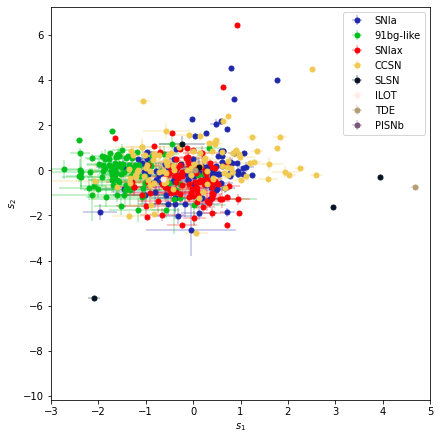

In [5]:
sn_types = ['SNIa', '91bg-like', 'SNIax', 'CCSN', 'SLSN', 'ILOT', 'TDE', 'PISNb']
parsnip.plot_representation(pred_test, sn_types, idx1=1, idx2=2, max_count=100)
plt.xlim(-3,5)
plt.show()

#plt.savefig('./roman_classification12.pdf')

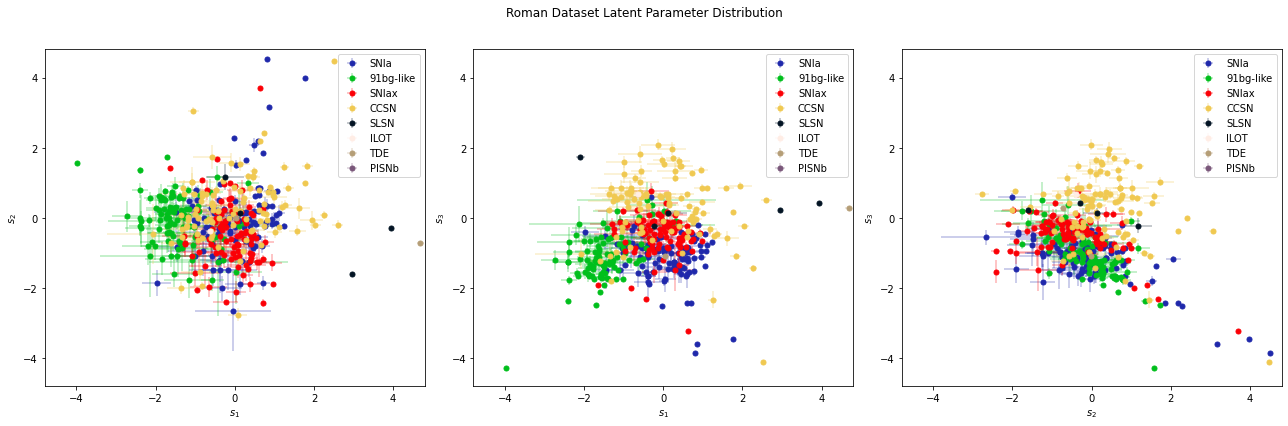

In [15]:



sn_types = ['SNIa', '91bg-like', 'SNIax', 'CCSN', 'SLSN', 'ILOT', 'TDE', 'PISNb']

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Roman Dataset Latent Parameter Distribution')

# Plot for each combination of indices
parsnip.plot_representation(pred_test, sn_types, idx1=1, idx2=2, max_count=100, ax=axs[0])
axs[0].set_xlim(-4.8,4.8)
axs[0].set_ylim(-4.8,4.8)
parsnip.plot_representation(pred_test, sn_types, idx1=1, idx2=3, max_count=100, ax=axs[1])
axs[1].set_xlim(-4.8,4.8)
axs[1].set_ylim(-4.8,4.8)
parsnip.plot_representation(pred_test, sn_types, idx1=2, idx2=3, max_count=100, ax=axs[2])
axs[2].set_xlim(-4.8,4.8)
axs[2].set_ylim(-4.8,4.8)

# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('./figures/roman_classification.pdf')
plt.show()


In [ ]:
bins = (
    (0, 0.25),
    (0.25, 0.5),
    (0.5, 1),
    (1, 2),
)

fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharex=True, sharey=True,
                         gridspec_kw={'wspace': 0.05, 'hspace': 0.02}, constrained_layout=True)

for idx in range(len(bins)):
    ax = axes[idx]
    min_z, max_z = bins[idx]
    predictions=preds

    mask = (predictions['redshift'] > min_z) & (predictions['redshift'] < max_z)
    use_pred = predictions[mask]
    use_pred.sort('total_s2n', reverse=True)

    kwargs = {}

    if idx == 3:
        kwargs['legend_ncol'] = 1
    else:
        kwargs['show_legend'] = False

    # Common plot
    parsnip.plot_representation(use_pred, roman_plot_labels, idx1=1, idx2=2, max_count=200,
                                markersize=3, ax=ax, **kwargs)
    ax.set_title(f'{min_z} < z < {max_z}')
    ax.set_xlim(-7., 7.)
    ax.set_ylim(-6, 6)
    if idx > 0:
        ax.set_ylabel('')
    ax.grid()
fig.savefig('roman_z_representation12.pdf')

In [ ]:
bins = (
    (0, 0.25),
    (0.25, 0.5),
    (0.5, 1),
    (1, 2),
)

fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharex=True, sharey=True,
                         gridspec_kw={'wspace': 0.05, 'hspace': 0.02}, constrained_layout=True)

for idx in range(len(bins)):
    ax = axes[idx]
    min_z, max_z = bins[idx]

    mask = (predictions['redshift'] > min_z) & (predictions['redshift'] < max_z)
    use_pred = predictions[mask]
    use_pred.sort('total_s2n', reverse=True)

    kwargs = {}

    if idx == 3:
        kwargs['legend_ncol'] = 1
    else:
        kwargs['show_legend'] = False

    # Common plot
    parsnip.plot_representation(use_pred, roman_plot_labels, idx1=1, idx2=3, max_count=200,
                                markersize=3, ax=ax, **kwargs)
    ax.set_title(f'{min_z} < z < {max_z}')
    ax.set_xlim(-7., 7.)
    ax.set_ylim(-6, 6)
    if idx > 0:
        ax.set_ylabel('')
    ax.grid()
fig.savefig('roman_z_representation13.pdf')

In [ ]:
bins = (
    (0, 0.25),
    (0.25, 0.5),
    (0.5, 1),
    (1, 2),
)

fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharex=True, sharey=True,
                         gridspec_kw={'wspace': 0.05, 'hspace': 0.02}, constrained_layout=True)

for idx in range(len(bins)):
    ax = axes[idx]
    min_z, max_z = bins[idx]

    mask = (predictions['redshift'] > min_z) & (predictions['redshift'] < max_z)
    use_pred = predictions[mask]
    use_pred.sort('total_s2n', reverse=True)

    kwargs = {}

    if idx == 3:
        kwargs['legend_ncol'] = 1
    else:
        kwargs['show_legend'] = False

    # Common plot
    parsnip.plot_representation(use_pred, roman_plot_labels, idx1=2, idx2=3, max_count=200,
                                markersize=3, ax=ax, **kwargs)
    ax.set_title(f'{min_z} < z < {max_z}')
    ax.set_xlim(-7., 7.)
    ax.set_ylim(-6, 6)
    if idx > 0:
        ax.set_ylabel('')
    ax.grid()
fig.savefig('roman_z_representation23.pdf')